## General information

This kernel is dedicated to EDA of Elo Merchant Category Recommendation competition as well as feature engineering.

In this dataset we can see clients who use Elo and their transactions. We need to predict the loyalty score for each card_id.

Work in progress.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10445/logos/thumb76_76.png?t=2018-10-24-17-14-05)

In [132]:
path_data =   "/Users/Simon/Desktop/JP/elo"
path_model ="/Users/Simon/Desktop/JP/elo models"

import os
try:
    os.stat(path_model)
except:
    os.mkdir(path_model) 
    
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

In [133]:
%%time
train = pd.read_csv(path_data + '/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv(path_data + '/test.csv', parse_dates=['first_active_month'])
submission = pd.read_csv(path_data + '/sample_submission.csv')

CPU times: user 429 ms, sys: 97.2 ms, total: 526 ms
Wall time: 541 ms


In [134]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Main data exploration
Let's have a look at data

In [135]:
e = pd.read_excel(path_data + '/Data_Dictionary.xlsx', sheet_name='train')
e

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months after historical and evaluation period


In [136]:
train['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [137]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null category
feature_2             201917 non-null category
feature_3             201917 non-null category
target                201917 non-null float64
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 5.2+ MB


We have a date column, three anonymized categorical columns and target.

### Features 1, 2, 3

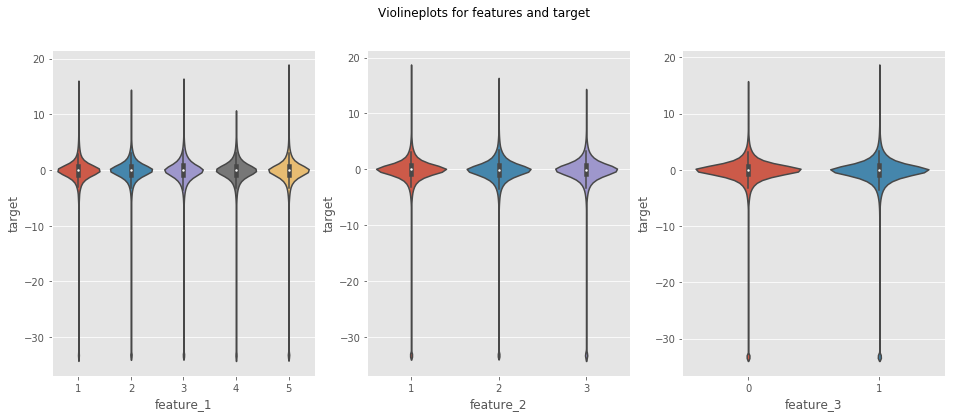

In [138]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target');
sns.violinplot(x="feature_1", y="target", data=train, ax=ax[0], title='feature_1');
sns.violinplot(x="feature_2", y="target", data=train, ax=ax[1], title='feature_2');
sns.violinplot(x="feature_3", y="target", data=train, ax=ax[2], title='feature_3');

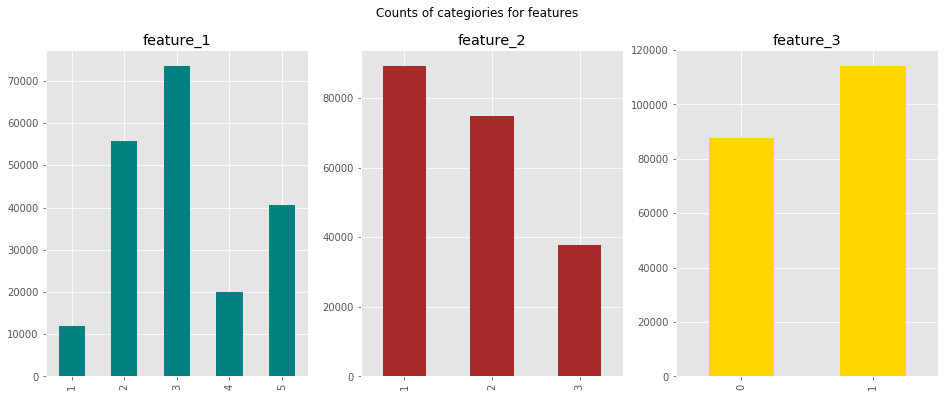

In [139]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3');
plt.suptitle('Counts of categiories for features');

These two plots show an important idea: while different categories of these features could have various counts, the distribution of target is almost the same. This could mean, that these features aren't really good at predicting target - we'll need other features and feature engineering.
Also it is worth noticing that mean target values of each catogory of these features is near zero. This could mean that data was sampled from normal distribution.

In [140]:
test['feature_1'] = test['feature_1'].astype('category')
test['feature_2'] = test['feature_2'].astype('category')
test['feature_3'] = test['feature_3'].astype('category')

### date

In [141]:
d1 = train['first_active_month'].value_counts().sort_index()
d2 = test['first_active_month'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Counts of first active",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

Trends of counts for train and test data are similar, and this is great.
Why there is such a sharp decline at the end of the period? I think it was on purpose. Or maybe new cards are taken into account only after fulfilling some conditions. 

Also there is one line with a missing data in test. I'll fill in with the first data, having the same values of features.

In [142]:
test.loc[test['first_active_month'].isna(), 'first_active_month'] = test.loc[(test['feature_1'] == 5) & (test['feature_2'] == 2) & (test['feature_3'] == 1), 'first_active_month'].min()

### target

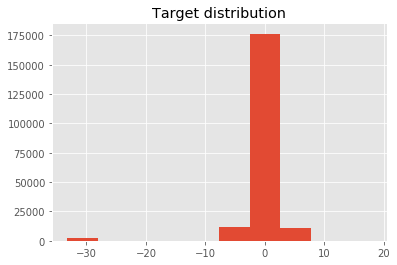

In [143]:
plt.hist(train['target']);
plt.title('Target distribution');

In [144]:
# print(y.describe())
# print(y.shape)
# print(y.quantile(0.01))
# train['target'].describe()


This looks really strange!

In [145]:
print('There are {0} samples with target lower than -20.'.format(train.loc[train.target < -20].shape[0]))



There are 2207 samples with target lower than -20.


And they have 1 unique value: -33.21928095.
This seems to be a special case. Maybe it would be reasonable to simply exclude these samples. We'll try later.

### Feature engineering

In [146]:
max_date = train['first_active_month'].dt.date.max()
def process_main(df):
    date_parts = ["year", "weekday", "month"]
    for part in date_parts:
        part_col = 'first_active_month' + "_" + part
        df[part_col] = getattr(df['first_active_month'].dt, part).astype(int)
            
    df['elapsed_time'] = (max_date - df['first_active_month'].dt.date).dt.days
    
    return df

In [147]:
train = process_main(train)
test = process_main(test)

## historical_transactions
Up to 3 months' worth of historical transactions for each card_id

In [148]:
historical_transactions = pd.read_csv(path_data + '/historical_transactions.csv')
e = pd.read_excel(path_data + '/Data_Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [149]:
print('%d samples in data'%historical_transactions.shape[0])
historical_transactions.head()

29112361 samples in data


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [150]:
# let's convert the authorized_flag to a binary value.
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

At average 91.3545% transactions are authorized


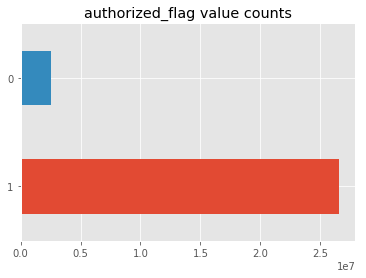

In [151]:
print("At average %.4f%% transactions are authorized"%(historical_transactions['authorized_flag'].mean() * 100))
historical_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

#### Cards with lowest and highest percentage of authorized transactions

In [152]:
autorized_card_rate = historical_transactions.groupby(['card_id'])['authorized_flag'].mean().sort_values()
autorized_card_rate.head()

card_id
C_ID_744d26ea32    0.030488
C_ID_bb8dd137c9    0.037037
C_ID_e56202cd39    0.042105
C_ID_4feacff118    0.050000
C_ID_c27b4f80f7    0.054545
Name: authorized_flag, dtype: float64

In [153]:
autorized_card_rate.tail()

card_id
C_ID_d048b7cc60    1.0
C_ID_4e45fcdb43    1.0
C_ID_9f3ee1305e    1.0
C_ID_1b52a3e21b    1.0
C_ID_d3c3d988d5    1.0
Name: authorized_flag, dtype: float64

In [154]:
count=0
for a in autorized_card_rate:
    if (a<0.2):
        count=count+1
print(count)


x=autorized_card_rate.index[0:count]
z=submission['card_id'][:]
h=[]

for a in x:
    h.append(a)
print(len(h))

147
147


In [155]:
historical_transactions=historical_transactions[~historical_transactions.card_id.isin(h)]

#historical_transactions=historical_transactions.drop(historical_transactions[historical_transactions['card_id'] ==x].index)



It seems that there are some cards, for which most of transactions were declined. Were this fraud transactions?

### installments

In [156]:
historical_transactions['installments'].value_counts()

 0      15410522
 1      11661725
 2        666138
 3        537864
 4        179254
-1        178134
 6        132339
 10       118526
 5        115840
 12        54837
 8         20402
 7         10867
 9          5756
 11          821
 999         188
Name: installments, dtype: int64

historical_transactions['authorized_flag'].isna().values.any()

#historical_transactions=historical_transactions[historical_transactions['card_id'] !='C_ID_bb8dd137c9']

historical_transactions.query('card_id != C_ID_e56202cd39  ')

Interesting. Most common number of installments are 0 and 1 which is expected. But -1 and 999 are strange. I think that these values were used to fill in missing values.

In [157]:
historical_transactions.groupby(['installments'])['authorized_flag'].mean()

installments
-1      0.885710
 0      0.928080
 1      0.908098
 2      0.884228
 3      0.862614
 4      0.820813
 5      0.810463
 6      0.781161
 7      0.695592
 8      0.694589
 9      0.665219
 10     0.703424
 11     0.667479
 12     0.655670
 999    0.031915
Name: authorized_flag, dtype: float64

In [158]:
historical_transactions['authorized_flag'].value_counts()

1    26592781
0     2500432
Name: authorized_flag, dtype: int64

On the other hand it seems that `999` could mean fraud transactions, considering only 3% of these transactions were approved. One more interesting thing is that the higher the number of installments is, the lower is the approval rate.

In [159]:
historical_transactions['installments'] = historical_transactions['installments'].astype('category')

In [160]:
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'])


historical_transactions=historical_transactions.drop(historical_transactions[historical_transactions['installments'] ==999].index)
#historical_transactions=historical_transactions.drop(historical_transactions[historical_transactions['installments'] ==-1].index)


### purchase_amount
Sadly purchase_amount is normalized. Let's have a look at it nevertheless.

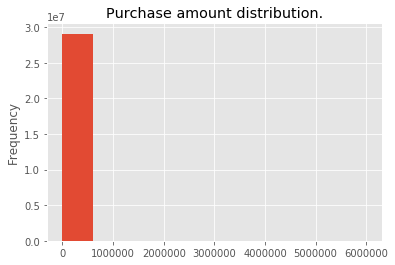

In [161]:
plt.title('Purchase amount distribution.');
historical_transactions['purchase_amount'].plot(kind='hist');

In [162]:
for i in [-1, 0]:
    n = historical_transactions.loc[historical_transactions['purchase_amount'] < i].shape[0]
    print("There are %d transactions with purchase_amount less than %d."%(n, i))
for i in [0, 5,7,8,9,10,100]:
    n = historical_transactions.loc[historical_transactions['purchase_amount'] > i].shape[0]
    print("There are %d transactions with purchase_amount more than %d."%(n, i))

There are 0 transactions with purchase_amount less than -1.
There are 28018346 transactions with purchase_amount less than 0.
There are 1074669 transactions with purchase_amount more than 0.
There are 47550 transactions with purchase_amount more than 5.
There are 26341 transactions with purchase_amount more than 7.
There are 21715 transactions with purchase_amount more than 8.
There are 17741 transactions with purchase_amount more than 9.
There are 14908 transactions with purchase_amount more than 10.
There are 1183 transactions with purchase_amount more than 100.


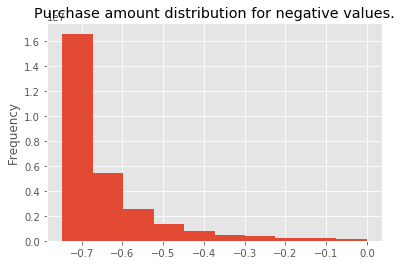

In [163]:
plt.title('Purchase amount distribution for negative values.');
historical_transactions.loc[historical_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist');

In [164]:
historical_transactions=historical_transactions.drop(historical_transactions[historical_transactions['purchase_amount'] >9].index)


It seems that almost all transactions have purchase amount in range (-1, 0). Quite a strong normalization and high outliers, which will need to be processed.

### Categories

In [165]:
map_dict = {'Y': 0, 'N': 1}
historical_transactions['category_1'] = historical_transactions['category_1'].apply(lambda x: map_dict[x])
historical_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                     authorized_flag          
                      mean       std     count            mean       std
category_1                                                              
0                -0.475557  0.715978   2064955        0.753717  0.430846
1                -0.593769  0.388937  27010329        0.926516  0.260929

In [166]:
historical_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                     authorized_flag          
                      mean       std     count            mean       std
category_2                                                              
1.0              -0.603130  0.367042  15168320        0.927743  0.258913
2.0              -0.577850  0.420830   1025904        0.906455  0.291195
3.0              -0.569528  0.447244   3909018        0.919088  0.272700
4.0              -0.592458  0.400513   2616007        0.927890  0.258670
5.0              -0.588382  0.387311   3722581        0.934593  0.247242

In [167]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
historical_transactions['category_3'] = historical_transactions['category_3'].apply(lambda x: map_dict[str(x)])
historical_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                     authorized_flag          
                      mean       std     count            mean       std
category_3                                                              
0                -0.638618  0.261842  15408622        0.928156  0.258229
1                -0.611920  0.324611  11656619        0.908205  0.288736
2                -0.021897  1.047040   1832855        0.838345  0.368134
3                -0.037405  1.035944    177188        0.886764  0.316882

All categories are quite different

In [168]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {historical_transactions[col].nunique()} unique values in {col}.")

There are 308 unique values in city_id.
There are 326 unique values in merchant_category_id.
There are 326089 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


### Feature engineering

In [170]:
# historical_transactions2 = historical_transactions.copy()
# trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
# trans

In [171]:
def aggregate_historical_transactions(trans, prefix):
    trans['purchase_month'] = trans['purchase_date'].dt.month
#     trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']). \
#                                         astype(np.int64) * 1e-9
    trans['installments'] = trans['installments'].astype(int)
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [172]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    history['installments'] = history['installments'].astype(int)
    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group = aggregate_per_month(historical_transactions) 

In [173]:
%%time
del d1, d2, autorized_card_rate
gc.collect()
historical_transactions = reduce_mem_usage(historical_transactions)
history = aggregate_historical_transactions(historical_transactions, prefix='hist_')
gc.collect()
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')
del history

Mem. usage decreased to 2583.23 Mb (43.9% reduction)
CPU times: user 1min 52s, sys: 16.4 s, total: 2min 9s
Wall time: 2min 9s


In [174]:
del historical_transactions
gc.collect()

79

## new_merchant_transactions 
Two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

In [176]:
new_merchant_transactions = pd.read_csv(path_data + '/new_merchant_transactions.csv')
e = pd.read_excel(path_data + '/Data_Dictionary.xlsx', sheet_name='new_merchant_period')
e

,new_merchant_period.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [177]:
print('%d samples in data'%new_merchant_transactions.shape[0])
new_merchant_transactions.head()

1963031 samples in data


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [178]:
# let's convert the authorized_flag to a binary value.
new_merchant_transactions['authorized_flag'] = new_merchant_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

At average 100.0000% transactions are authorized


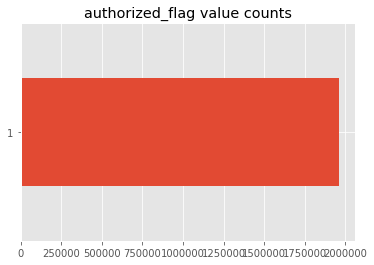

In [179]:
print("At average %.4f%% transactions are authorized"%(new_merchant_transactions['authorized_flag'].mean() * 100))
new_merchant_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

In contrast with historical data, **all** transactions here were authorized!

#### Cards with lowest and highest total purchase amount

In [180]:
card_total_purchase = new_merchant_transactions.groupby(['card_id'])['purchase_amount'].sum().sort_values()
card_total_purchase.head()

card_id
C_ID_b7ebee6539   -70.813489
C_ID_8946508722   -63.907274
C_ID_c729288535   -61.042650
C_ID_6cef1dba4b   -60.780407
C_ID_0e4f6af077   -60.017000
Name: purchase_amount, dtype: float64

In [181]:
card_total_purchase.tail()

card_id
C_ID_72613043cf    109.086210
C_ID_01314ceccf    113.317420
C_ID_a9435eee72    145.168997
C_ID_a289e7edd4    172.182653
C_ID_ca850ecf25    263.157498
Name: purchase_amount, dtype: float64

It seems that there are some cards, for which most of transactions were declined. Were this fraud transactions?

### installments

In [182]:
new_merchant_transactions['installments'].value_counts()

 0      922244
 1      836178
-1       55922
 2       54729
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

Interesting. Most common number of installments are 0 and 1 which is expected. But -1 and 999 are strange. I think that these values were used to fill in missing values.

In [183]:
new_merchant_transactions.groupby(['installments'])['purchase_amount'].sum()

installments
-1        1903.176718
 0     -581948.746520
 1     -507130.345871
 2      -21592.186709
 3       -6669.938153
 4        3212.909351
 5        2641.835005
 6        6994.802878
 7         522.470989
 8        1927.359352
 9         958.387496
 10      13864.551233
 11        117.734959
 12       3627.758765
 999         1.005048
Name: purchase_amount, dtype: float64

In [184]:
new_merchant_transactions['installments'] = new_merchant_transactions['installments'].astype('category')




new_merchant_transactions=new_merchant_transactions.drop(new_merchant_transactions[new_merchant_transactions['installments']==999].index)
#new_merchant_transactions=new_merchant_transactions.drop(new_merchant_transactions[new_merchant_transactions['installments']==-1].index)





### purchase_amount
Sadly purchase_amount is normalized. Let's have a look at it nevertheless.

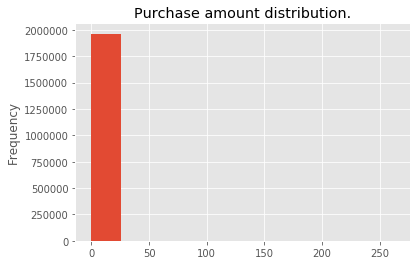

In [185]:
plt.title('Purchase amount distribution.');
new_merchant_transactions['purchase_amount'].plot(kind='hist');

In [186]:
for i in [-1, 0]:
    n = new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] < i].shape[0]
    print(f"There are {n} transactions with purchase_amount less than {i}.")
for i in [0,  5,7,8,9,10,100]:
    n = new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] > i].shape[0]
    print(f"There are {n} transactions with purchase_amount more than {i}.")

There are 0 transactions with purchase_amount less than -1.
There are 1877356 transactions with purchase_amount less than 0.
There are 85673 transactions with purchase_amount more than 0.
There are 3458 transactions with purchase_amount more than 5.
There are 1885 transactions with purchase_amount more than 7.
There are 1509 transactions with purchase_amount more than 8.
There are 1209 transactions with purchase_amount more than 9.
There are 996 transactions with purchase_amount more than 10.
There are 2 transactions with purchase_amount more than 100.


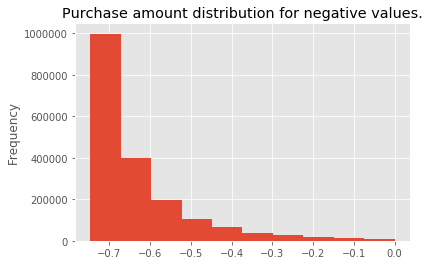

In [187]:
plt.title('Purchase amount distribution for negative values.');
new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist');

It seems that almost all transactions have purchase amount in range (-1, 0). Quite a strong normalization and high outliers, which will need to be processed.

In [188]:
new_merchant_transactions=new_merchant_transactions.drop(new_merchant_transactions[new_merchant_transactions['purchase_amount'] >9].index)



### Categories

In [189]:
map_dict = {'Y': 0, 'N': 1}
new_merchant_transactions['category_1'] = new_merchant_transactions['category_1'].apply(lambda x: map_dict[x])
new_merchant_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                   
                      mean       std    count
category_1                                   
0                -0.273718  0.946061    62879
1                -0.571031  0.423553  1898941

In [190]:
new_merchant_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                   
                      mean       std    count
category_2                                   
1.0              -0.578543  0.411952  1057691
2.0              -0.561596  0.430791    65638
3.0              -0.558816  0.443229   289388
4.0              -0.566142  0.430729   178493
5.0              -0.559813  0.440935   259098

In [191]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
new_merchant_transactions['category_3'] = new_merchant_transactions['category_3'].apply(lambda x: map_dict[str(x)])
new_merchant_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                  
                      mean       std   count
category_3                                  
0                -0.631461  0.257906  922209
1                -0.610806  0.291422  835987
2                -0.040030  1.017107  147988
3                -0.048121  0.998228   55636

All categories are quite different

In [192]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {new_merchant_transactions[col].nunique()} unique values in {col}.")

There are 308 unique values in city_id.
There are 314 unique values in merchant_category_id.
There are 225979 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


In [193]:
new_merchant_transactions['purchase_date'] = pd.to_datetime(new_merchant_transactions['purchase_date'])

### Feature engineering

In [195]:
def aggregate_historical_transactions(trans, prefix):
    trans['purchase_month'] = trans['purchase_date'].dt.month
#     trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    trans['installments'] = trans['installments'].astype(int)
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [196]:
%%time
gc.collect()
new_transactions = reduce_mem_usage(new_merchant_transactions)
history = aggregate_historical_transactions(new_merchant_transactions, prefix='new')
del new_merchant_transactions
gc.collect()
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')
del history
gc.collect()

Mem. usage decreased to 167.93 Mb (42.4% reduction)
CPU times: user 53.5 s, sys: 2.35 s, total: 55.9 s
Wall time: 55.5 s


In [197]:
train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')
gc.collect()
del final_group

In [198]:
test.shape

(123623, 123)

## merchants
Aggregate information for each merchant_id

In [199]:
merchants = pd.read_csv(path_data + '/merchants.csv')
e = pd.read_excel(path_data + '/Data_Dictionary.xlsx', sheet_name='merchant')
e

,merchants.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,merchant_id,Unique merchant identifier
3,merchant_group_id,Merchant group (anonymized )
4,merchant_category_id,Unique identifier for merchant category (anonymized )
5,subsector_id,Merchant category group (anonymized )
6,numerical_1,anonymized measure
7,numerical_2,anonymized measure
8,category_1,anonymized category
9,most_recent_sales_range,Range of revenue (monetary units) in last active month --> A > B > C > D > E


In [200]:
print('%d merchants in data'%merchants.shape[0])
merchants.head()

334696 merchants in data


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [201]:
# encoding categories.
map_dict = {'Y': 0, 'N': 1}
merchants['category_1'] = merchants['category_1'].apply(lambda x: map_dict[x])
merchants.loc[merchants['category_2'].isnull(), 'category_2'] = 0
merchants['category_4'] = merchants['category_4'].apply(lambda x: map_dict[x])

In [202]:
merchants['merchant_category_id'].nunique(), merchants['merchant_group_id'].nunique()

(324, 109391)

### numerical_1

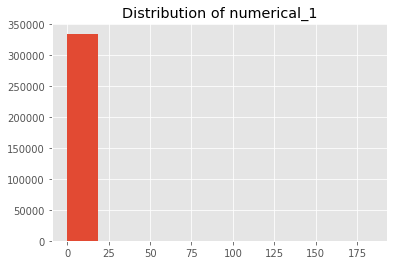

In [203]:
plt.hist(merchants['numerical_1']);
plt.title('Distribution of numerical_1');

In [204]:
np.percentile(merchants['numerical_1'], 95)

0.09125291

Well, 95% of values are less than 0.1, we'll need to deal with outliers.

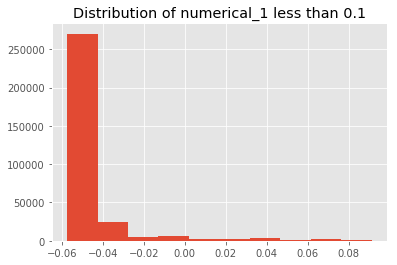

In [205]:
plt.hist(merchants.loc[merchants['numerical_1'] < 0.1, 'numerical_1']);
plt.title('Distribution of numerical_1 less than 0.1');

In [206]:
min_n1 = merchants['numerical_1'].min()
_ = sum(merchants['numerical_1'] == min_n1) / merchants['numerical_1'].shape[0]
print(f'{_ * 100:.4f}% of values in numerical_1 are equal to {min_n1}')

68.3570% of values in numerical_1 are equal to -0.05747065


In fact more than a half values are equal to minimum value. A very skewered distribution.

### Numerical_2

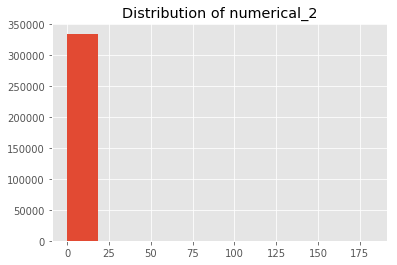

In [207]:
plt.hist(merchants['numerical_2']);
plt.title('Distribution of numerical_2');

68.3570% of values in numerical_1 are equal to -0.05747065


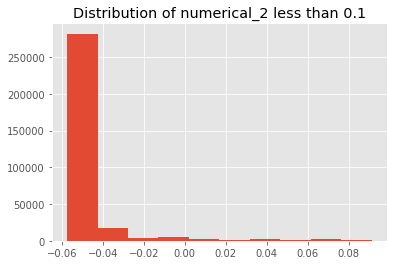

In [208]:
plt.hist(merchants.loc[merchants['numerical_2'] < 0.1, 'numerical_2']);
plt.title('Distribution of numerical_2 less than 0.1');
min_n1 = merchants['numerical_1'].min()
_ = sum(merchants['numerical_1'] == min_n1) / merchants['numerical_1'].shape[0]
print(f'{_ * 100:.4f}% of values in numerical_1 are equal to {min_n1}')

In [209]:
(merchants['numerical_1'] != merchants['numerical_2']).sum() / merchants.shape[0]

0.10056289886942181

These two variables are very similar. In fact for 90% merchants they are the same.

> most_recent_sales_range 	most_recent_purchases_range 	avg_sales_lag3 	avg_purchases_lag3 	active_months_lag3 	avg_sales_lag6 	avg_purchases_lag6 	active_months_lag6 	avg_sales_lag12 	avg_purchases_lag12 	active_months_lag12

### most_recent_sales_range

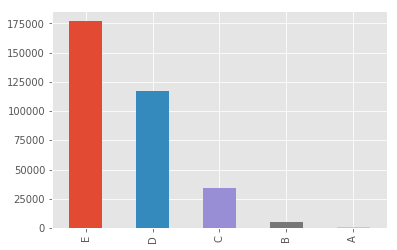

In [210]:
merchants['most_recent_sales_range'].value_counts().plot('bar');

In [211]:
d = merchants['most_recent_sales_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_sales_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_sales_range",
                        xaxis = dict(title = 'most_recent_sales_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

We can see that these ranges have different counts and different mean value of numerical_1 even after removing outliers.

### most_recent_purchases_range

In [212]:
d = merchants['most_recent_purchases_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_purchases_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_purchases_range",
                        xaxis = dict(title = 'most_recent_purchases_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

These two variables seem to be quite similar.

### avg_sales_lag

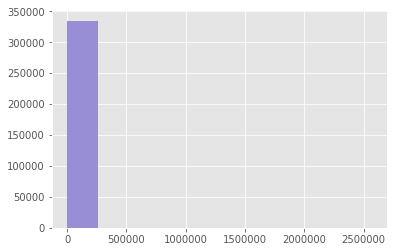

In [213]:
plt.hist(merchants['avg_sales_lag3'].fillna(0));
plt.hist(merchants['avg_sales_lag6'].fillna(0));
plt.hist(merchants['avg_sales_lag12'].fillna(0));

In [214]:
for col in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
    print(f'Max value of {col} is {merchants[col].max()}')
    print(f'Min value of {col} is {merchants[col].min()}')

Max value of avg_sales_lag3 is 851844.64
Min value of avg_sales_lag3 is -82.13
Max value of avg_sales_lag6 is 1513959.0
Min value of avg_sales_lag6 is -82.13
Max value of avg_sales_lag12 is 2567408.0
Min value of avg_sales_lag12 is -82.13


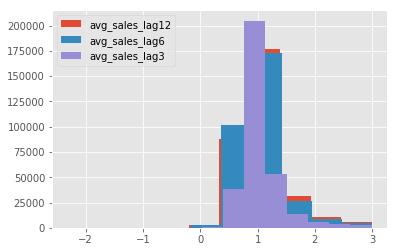

In [215]:
plt.hist(merchants.loc[(merchants['avg_sales_lag12'] < 3) & (merchants['avg_sales_lag12'] > -10), 'avg_sales_lag12'].fillna(0), label='avg_sales_lag12');
plt.hist(merchants.loc[(merchants['avg_sales_lag6'] < 3) & (merchants['avg_sales_lag6'] > -10), 'avg_sales_lag6'].fillna(0), label='avg_sales_lag6');
plt.hist(merchants.loc[(merchants['avg_sales_lag3'] < 3) & (merchants['avg_sales_lag3'] > -10), 'avg_sales_lag3'].fillna(0), label='avg_sales_lag3');
plt.legend();

Distribution of these values is quite similar and most values are between 0 and 2.

### avg_purchases_lag

In [216]:
merchants['avg_purchases_lag3'].nlargest()

10                inf
11                inf
12                inf
235      6.185133e+04
13168    1.730000e+03
Name: avg_purchases_lag3, dtype: float64

We even have infinite values...

In [217]:
merchants.loc[merchants['avg_purchases_lag3'] == np.inf, 'avg_purchases_lag3'] = 6000
merchants.loc[merchants['avg_purchases_lag6'] == np.inf, 'avg_purchases_lag6'] = 6000
merchants.loc[merchants['avg_purchases_lag12'] == np.inf, 'avg_purchases_lag12'] = 6000

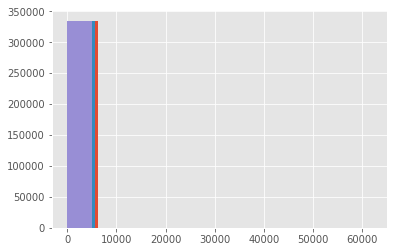

In [218]:
plt.hist(merchants['avg_purchases_lag3'].fillna(0));
plt.hist(merchants['avg_purchases_lag6'].fillna(0));
plt.hist(merchants['avg_purchases_lag12'].fillna(0));

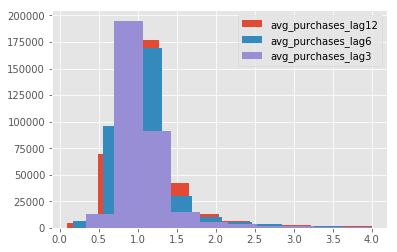

In [219]:
plt.hist(merchants.loc[(merchants['avg_purchases_lag12'] < 4), 'avg_purchases_lag12'].fillna(0), label='avg_purchases_lag12');
plt.hist(merchants.loc[(merchants['avg_purchases_lag6'] < 4), 'avg_purchases_lag6'].fillna(0), label='avg_purchases_lag6');
plt.hist(merchants.loc[(merchants['avg_purchases_lag3'] < 4), 'avg_purchases_lag3'].fillna(0), label='avg_purchases_lag3');
plt.legend();

In [220]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,1,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,1,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,1,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,1,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,1,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,1,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,0,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,0,-1,-1,0.0
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,0,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,0,-1,-1,0.0


## For now I won't use merchants data in models.

### Processing data for modelling

In [221]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_category_2_2.0_mean,hist_category_2_2.0_sum,hist_category_2_3.0_mean,hist_category_2_3.0_sum,hist_category_2_4.0_mean,hist_category_2_4.0_sum,hist_category_2_5.0_mean,hist_category_2_5.0_sum,hist_category_3_1_sum,hist_category_3_1_mean,hist_category_3_2_sum,hist_category_3_2_mean,hist_category_3_3_sum,hist_category_3_3_mean,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,newtransactions_count,newcategory_1_sum,newcategory_1_mean,newcategory_2_1.0_mean,newcategory_2_1.0_sum,newcategory_2_2.0_mean,newcategory_2_2.0_sum,newcategory_2_3.0_mean,newcategory_2_3.0_sum,newcategory_2_4.0_mean,newcategory_2_4.0_sum,newcategory_2_5.0_mean,newcategory_2_5.0_sum,newcategory_3_1_sum,newcategory_3_1_mean,newcategory_3_2_sum,newcategory_3_2_mean,newcategory_3_3_sum,newcategory_3_3_mean,newmerchant_id_nunique,newpurchase_amount_sum,newpurchase_amount_mean,newpurchase_amount_max,newpurchase_amount_min,newpurchase_amount_std,newinstallments_sum,newinstallments_mean,newinstallments_max,newinstallments_min,newinstallments_std,newpurchase_month_mean,newpurchase_month_max,newpurchase_month_min,newpurchase_month_std,newpurchase_date_ptp,newpurchase_date_max,newpurchase_date_min,newmonth_lag_min,newmonth_lag_max,newmerchant_category_id_nunique,newstate_id_nunique,newsubsector_id_nunique,newcity_id_nunique,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,3,6,245,260.0,247.0,0.950000,260.0,1.000000,0.988462,257.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.011538,3.0,4.0,0.015385,0.0,0.000000,0.0,0.000000,94.0,-166.000000,-0.638184,2.257812,-0.739258,0.212036,4.0,0.015385,1.0,0.0,0.123314,8.057692,12.0,1.0,3.474193,242 days 19:13:07,2018-02-25 09:31:15,2017-06-27 14:18:08,-8.0,0.0,41.0,3.0,21.0,7.0,23.0,23.0,1.000000,1.000000,23.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,23.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,0.0,0.000000,0.0,0.0,0.000000,3.478261,4.0,3.0,0.510754,54 days 21:18:29,2018-04-29 11:23:05,2018-03-05 14:04:36,1.0,2.0,14.0,1.0,10.0,3.0,-4.000000,2.738613,28.888889,17.244162,-18.440971,10.472169,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152,28.888889,17.244162,0.444444,0.726483,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,6,1,396,350.0,339.0,0.968571,319.0,0.911429,0.911429,319.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,276.0,0.788571,72.0,0.205714,2.0,0.005714,142.0,-210.000000,-0.600098,4.628906,-0.742188,0.385010,543.0,1.551429,10.0,-1.0,1.510777,6.220000,12.0,1.0,3.848142,390 days 06

### missing imputation. 
    Can we do something better?

In [222]:
def avg_time(datetime):
    sss=datetime
    sss=sss.dropna()
    length=len(sss)
    total=sum((dt.year)*3600*24*30*12+dt.month*3600*24*30+dt.day*3600*24+dt.hour * 3600 + dt.minute * 60 + dt.second for dt in sss)
    avg=total/length
    year=int(avg/(3600*24*30*12))
    avg=avg%(3600*24*30*12)
    month=int(avg/(3600*24*30))
    avg=avg%(3600*24*30)
    day=int(avg/(3600*24))
    avg=avg%(3600*24)
    hour=int(avg/3600)
    avg=avg%(3600)
    minute=int(avg/60)
    second=int(avg%60)
    return (year,month,day,hour,minute,second)

for col in train.columns:
    if train[col].isna().any():
        if train[col].dtype ==np.float64 or train[col].dtype ==np.float16 or type(train[col][2]) == pd._libs.tslibs.timedeltas.Timedelta:
            train[col]=train[col].fillna(train[col].mean()*)
        else:
            x=avg_time(train[col])
            train[col]=train[col].fillna(0)
            
#train[col].mean()*1.3
#datetime.datetime(x[0],x[1],x[2],x[3],x[4],x[5])


for col in test.columns:
    if test[col].isna().any():
        if test[col].dtype ==np.float64 or test[col].dtype ==np.float16 or type(test[col][2]) == pd._libs.tslibs.timedeltas.Timedelta:
            test[col]=test[col].fillna(test[col].mean()*0.1)
        else:
            x=avg_time(test[col])
            d=datetime.datetime(x[0],x[1],x[2],x[3],x[4],x[5])
            test[col]=test[col].fillna(0)

In [223]:
y = train['target']

In [224]:
col_to_drop = ['first_active_month', 'card_id', 'target']

In [225]:
for col in col_to_drop:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [226]:
train['feature_3'] = train['feature_3'].astype(int)
test['feature_3'] = test['feature_3'].astype(int)

In [227]:
categorical_feats = ['feature_1', 'feature_2']

for col in categorical_feats:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [228]:
train.head()

,feature_1,feature_2,feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_category_2_2.0_mean,hist_category_2_2.0_sum,hist_category_2_3.0_mean,hist_category_2_3.0_sum,hist_category_2_4.0_mean,hist_category_2_4.0_sum,hist_category_2_5.0_mean,hist_category_2_5.0_sum,hist_category_3_1_sum,hist_category_3_1_mean,hist_category_3_2_sum,hist_category_3_2_mean,hist_category_3_3_sum,hist_category_3_3_mean,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,newtransactions_count,newcategory_1_sum,newcategory_1_mean,newcategory_2_1.0_mean,newcategory_2_1.0_sum,newcategory_2_2.0_mean,newcategory_2_2.0_sum,newcategory_2_3.0_mean,newcategory_2_3.0_sum,newcategory_2_4.0_mean,newcategory_2_4.0_sum,newcategory_2_5.0_mean,newcategory_2_5.0_sum,newcategory_3_1_sum,newcategory_3_1_mean,newcategory_3_2_sum,newcategory_3_2_mean,newcategory_3_3_sum,newcategory_3_3_mean,newmerchant_id_nunique,newpurchase_amount_sum,newpurchase_amount_mean,newpurchase_amount_max,newpurchase_amount_min,newpurchase_amount_std,newinstallments_sum,newinstallments_mean,newinstallments_max,newinstallments_min,newinstallments_std,newpurchase_month_mean,newpurchase_month_max,newpurchase_month_min,newpurchase_month_std,newpurchase_date_ptp,newpurchase_date_max,newpurchase_date_min,newmonth_lag_min,newmonth_lag_max,newmerchant_category_id_nunique,newstate_id_nunique,newsubsector_id_nunique,newcity_id_nunique,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,4,1,1,2017,3,6,245,260.0,247.0,0.950000,260.0,1.000000,0.988462,257.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.011538,3.0,4.0,0.015385,0.0,0.000000,0.0,0.000000,94.0,-166.000000,-0.638184,2.257812,-0.739258,0.212036,4.0,0.015385,1.0,0.0,0.123314,8.057692,12.0,1.0,3.474193,242 days 19:13:07,2018-02-25 09:31:15,2017-06-27 14:18:08,-8.0,0.0,41.0,3.0,21.0,7.0,23.0,23.0,1.000000,1.000000,23.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,23.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,0.0,0.000000,0.0,0.0,0.000000,3.478261,4.0,3.0,0.510754,54 days 21:18:29,2018-04-29 11:23:05,2018-03-05 14:04:36,1.0,2.0,14.0,1.0,10.0,3.0,-4.000000,2.738613,28.888889,17.244162,-18.440971,10.472169,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152,28.888889,17.244162,0.444444,0.726483,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067
1,3,0,0,2017,6,1,396,350.0,339.0,0.968571,319.0,0.911429,0.911429,319.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,276.0,0.788571,72.0,0.205714,2.0,0.005714,142.0,-210.000000,-0.600098,4.628906,-0.742188,0.385010,543.0,1.551429,10.0,-1.0,1.510777,6.220000,12.0,1.0,3.848142,390 days 06:01:27,2018-01-31 22:31:09,2017-01-06 16:29:42,-12.0,0.0,57.0,3.0,24.0,9.0,6.0,6.0,1.000000,1.000000,6.0,0.

In [229]:
# for col in ['newpurchase_amount_max', 'newpurchase_date_max', 'purchase_amount_max_mean']:
for col in ['newpurchase_amount_max', 'purchase_amount_max_mean']:
    train[col + '_to_mean'] = train[col] / train[col].mean()
    test[col + '_to_mean'] = test[col] / test[col].mean()

### convert date to int

Drop these cols for now

    hist_purchase_date_ptp
    hist_purchase_date_max
    hist_purchase_date_min
    newpurchase_date_ptp
    newpurchase_date_max
    newpurchase_date_min

In [230]:
def convert_date(data, cols):
#     for col in cols:
#         data.loc[:, col] = pd.DatetimeIndex(data[col]).astype(np.int64) * 1e-9
    data.drop(cols, axis=1, inplace=True)
    return data

train = convert_date(train, \
                     ['hist_purchase_date_ptp','hist_purchase_date_max','hist_purchase_date_min', \
                      'newpurchase_date_ptp','newpurchase_date_max','newpurchase_date_min'])
test = convert_date(test, \
                     ['hist_purchase_date_ptp','hist_purchase_date_max','hist_purchase_date_min', \
                      'newpurchase_date_ptp','newpurchase_date_max','newpurchase_date_min'])

### Basic LGB model

In [231]:
X = train
X_test = test

#### Code for training models

In [232]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [233]:
def train_model(X=X, X_test=X_test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid)
            score = mean_squared_error(y_valid, y_pred_valid) ** 0.5
            print('Fold %d. RMSE: %.4f.'%(fold_n, score))
            print('')
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [234]:
params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,}

Fold 0 started at Sat Dec 29 22:53:59 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[402]	training's rmse: 3.53037	valid_1's rmse: 3.6392
Fold 1 started at Sat Dec 29 22:54:18 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[573]	training's rmse: 3.47494	valid_1's rmse: 3.79231
Fold 2 started at Sat Dec 29 22:54:41 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[534]	training's rmse: 3.49822	valid_1's rmse: 3.66667
Fold 3 started at Sat Dec 29 22:55:04 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[541]	training's rmse: 3.49011	valid_1's rmse: 3.71669
Fold 4 started at Sat Dec 29 22:55:26 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[441]	training's rmse: 3.51091	valid_1's rmse: 3.75415
Fold 5 started at Sat

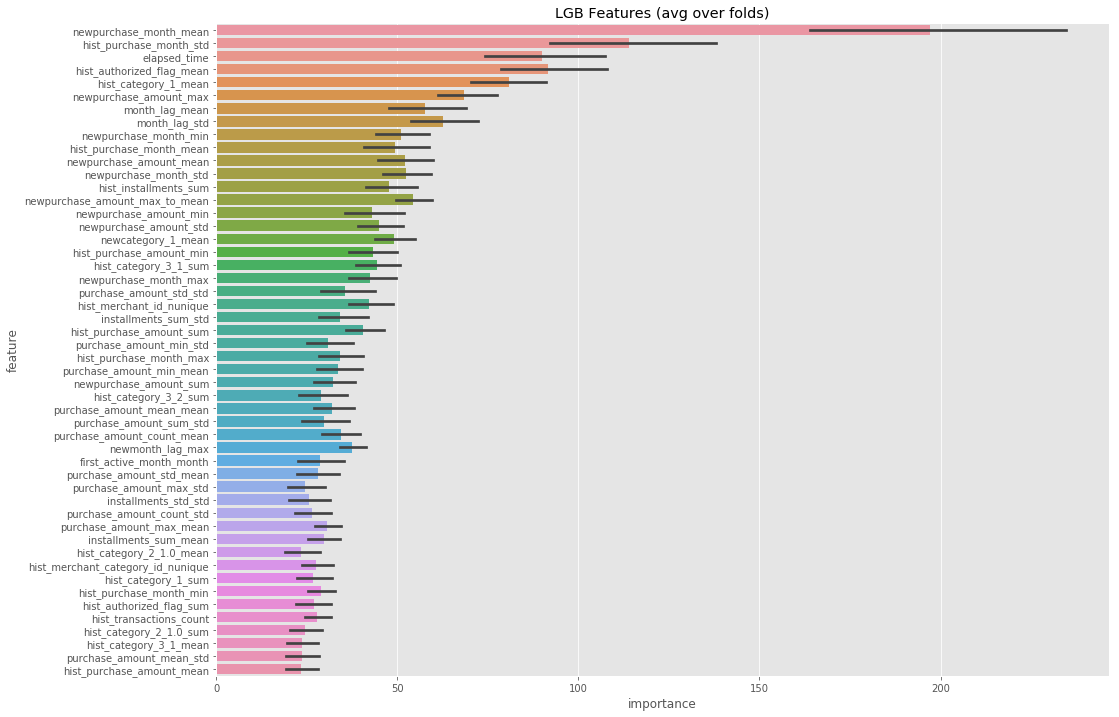

In [235]:
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, \
                                                          model_type='lgb', \
                                                          plot_feature_importance=True)

In [236]:
submission['target'] = prediction_lgb
submission.to_csv(path_model + '/lgb.csv', index=False)

In [ ]:
#train.isna().values.any()

In [115]:
xgb_params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgb')

NameError: name 'train_model' is not defined

In [ ]:
submission['target'] = prediction_xgb
submission.to_csv(path_model + '/xgb.csv', index=False)

In [ ]:
oof_rcv, prediction_rcv = train_model(params=None, model_type='rcv')

In [ ]:
submission['target'] = prediction_rcv
submission.to_csv(path_model + '/rcv.csv', index=False)

In [ ]:
cat_params = {'learning_rate': 0.01,
              'depth': 9,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat = train_model(params=cat_params, model_type='cat')

In [ ]:
submission['target'] = (prediction_lgb + prediction_xgb + prediction_rcv + prediction_cat) / 4
submission.to_csv(path_model + '/blend.csv', index=False)

In [ ]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_rcv, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack)
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_rcv, prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

In [ ]:
oof_lgb_stack, prediction_lgb_stack = train_model(X=train_stack, X_test=test_stack, params=params, model_type='lgb')

In [ ]:
sample_submission = pd.read_csv(path_data + '/sample_submission.csv')
sample_submission['target'] = prediction_lgb_stack
sample_submission.to_csv(path_model + '/stacker_lgb.csv', index=False)

In [ ]:
oof_rcv_stack, prediction_rcv_stack = train_model(X=train_stack, X_test=test_stack, params=None, model_type='rcv')

In [ ]:
sample_submission = pd.read_csv(path_data + '/sample_submission.csv')
sample_submission['target'] = prediction_rcv_stack
sample_submission.to_csv(path_model + '/stacker_rcv.csv', index=False)